# Predicting Startup Success

As investors we want to know which companies will succeed and which companies will fail so we can make smart investments.  Unfortuanetly there is no way to know ahead of time which companies will succeed or fauk, however, we can try to predict success based on the huge amounts of data available online about startups.  For this project we will be analyzing data obtained through the [CrunchBase](https://www.crunchbase.com/) API.

The CrunchBase dataset, while extensive provides us with data that is pretty biased.  In order to be in the CrunchBase database, a company must already have become newsworthy.  Normally that means raising a significant round of funding or graduating from a prominent incubator.  We will take this bias into account when performing our analysis.  Simply raising one round of funding will not be considered a succesful outcome.

So how will we define success?  We will use a couple of indicators, and if a company achieves even a single one of these, we will consider the startup to be successful.  

So what are the indicators we are using? We will consider a company to be a success if it IPOs or if it is acquired (even though we are aware that many acquisitions may not be considered successes by employees or investors in a company, for this project we will be making this simplification and assuming all acquisitions are successes).  We will also consider a startup a success if it has raised several rounds of funding.  How many?  Well, since all the startups in the CrunchBase database have already raised one round, we will pretend we are making a second round investment.  Any companies that raise a thrid round will be considered succesful as they have proven that other investors are interested in investing in this company after us.  Later we will show another reason why we chose 3 as a cutoff in the number of rounds of investment to be considered successful.

Not all companies are equally successful.  And perhaps it is best to weight your investments based on how certain you are that a company will succeed and how succesful that company will be, in terms of what the rate of return for a particular company is.  However, since we don't have all of the financial information for funding rounds, and none of the financial information for rate of return for different investors in different rounds of different companies, we will simply focus in this project on the overall success or failure of a company and treat this as a classification problem, rather than a regression problem.

##Data Cleaning

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import datetime
import time

In [2]:
with open("tmp/organizations_dict.json", "r") as fd:
    orgs = json.load(fd)

In [3]:
df=pd.DataFrame(orgs.values(),index=orgs.keys())

Copied this from HW5, to get adjectives and nouns from the short_description

In [4]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
# taken from HW5
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2


In [5]:
# add column for description nouns and adjectives
df['text_nouns']=df.short_description.map(lambda x: None if x==None else get_parts(x)[0])
df['text_adjectives']=df.short_description.map(lambda x: None if x==None else get_parts(x)[1])

In [6]:
# add indicator columns for each category
catlist=df.categories.map(lambda x: None if x==None or isinstance(x,float) else [a['name'] for a in x]).tolist()
catset=set([item for sublist  in catlist if sublist!=None for item in sublist])
for category in catset:
    df["c_"+category+"_i"]=pd.Series(catlist, index=df.index).map(lambda x: category in x if x else False)

In [7]:
# add indicator columns for investors
investorslist=df.investors.map(lambda x: None if x==None or isinstance(x,float) else [a['permalink'] for a in x]).tolist()
investorset=set([item for sublist  in investorslist if sublist!=None for item in sublist])
for inv in investorset:
    df["i_"+inv+"_i"]=pd.Series(investorslist, index=df.index).map(lambda x: inv in x if x else False)

In [8]:
# add indicator columns for cities (from offices)
citylist=df.offices.map(lambda x: None if not x or isinstance(x,float) else [a['city'] for a in x]).tolist()
cityset=set([item for sublist  in citylist if sublist!=None for item in sublist])
for city in cityset:
    if city != None:
        df["city_"+city+"_i"]=pd.Series(citylist, index=df.index).map(lambda x: city in x if x else False)

After adding indicator columns, we now get some more data from the fields that currently exist as dictionaries/lists

In [9]:
df['funding_dates']=df.funding_rounds.map(lambda x:[] if not x or isinstance(x,float) else [datetime.datetime(*time.strptime(a['announced_on'], '%Y-%m-%d')[:3]) for a in x])

In [10]:
df['funding_amounts']=df.funding_rounds.map(lambda x:[] if not x or isinstance(x,float) else [float(a['money_raised_usd']) if a['money_raised_usd'] != None else 0 for a in x])

In [11]:
df['num_funding_rounds']=df.funding_amounts.map(lambda x: len(x))

In [55]:
df['funding_mean']=df.funding_amounts.map(lambda x: np.mean(x))
df['funding_total']=df.funding_amounts.map(lambda x: np.sum(x))

In [13]:
df['went_ipo']=df.ipo.map(lambda x: True if x else False)

In [329]:
df['was_acquired']=df.acquired_by.map(lambda x: True if x else False)

In [357]:
df['founder_names']=df.founders.map(lambda x:[] if not x or isinstance(x,float) else [a['permalink']  for a in x])
df['num_founders']=df.founders.map(lambda x: np.count_nonzero(x))

In [344]:
df['founder_ages'] = df.founders.map(lambda x:[] if not x or isinstance(x,float) else [(datetime.date.today()-datetime.date(*time.strptime(a['born_on'],'%Y-%m-%d')[:3])).days/365 for a in x if isinstance(a['born_on'],unicode)])
df['founder_ages_mean'] = df.founder_ages.map(lambda x: np.mean(x) if len(x) >0 else 0)
df['num_competitors'] = df.competitors.map(lambda x: np.count_nonzero(x))

In [358]:
df.head()

,acquired_by,acquisitions,board_members_and_advisors,categories,competitors,founders,funding_rounds,headquarters,investments,investors,ipo,offices,owned_by,short_description,text_nouns,text_adjectives,c_Marketplaces_i,c_Crowdsourcing_i,c_Anything Capital Intensive_i,c_B2B_i,c_Corporate IT_i,c_Health and Insurance_i,c_Crowdfunding_i,c_Corporate Training_i,c_Incentives_i,c_Communications Infrastructure_i,c_Tourism_i,c_Cloud Data Services_i,c_Training_i,c_Automated Kiosk_i,c_Social Media Marketing_i,c_Restaurants_i,c_Portals_i,c_Clinical Trials_i,c_Testing_i,c_Water Purification_i,c_Health Services Industry_i,c_SNS_i,c_Non Profit_i,c_Telecommunications_i,c_Ticketing_i,c_Language Learning_i,c_Video Streaming_i,c_Mobile Payments_i,c_3D_i,c_Automotive_i,c_Collaboration_i,c_Interior Design_i,c_M2M_i,c_Game_i,...,city_Runcorn_i,city_Kanata_i,city_Gaithersburg_i,city_Beverly Hills_i,city_Guayabo_i,city_Upper Heyford_i,city_Vancouver_i,city_Chandigarh_i,city_Reading_i,city_Geneva_i,city_Cherry Hill_i,city_Princeton_i,city_Elkridge_i,city_Plymouth Meeting_i,city_Malvern_i,city_Mount Vernon_i,city_Miass_i,city_Stanford_i,city_Wilmington_i,city_Arnold_i,city_Melbourne_i,city_Plymouth_i,city_Longwood_i,city_Palo Alto_i,city_Almaty_i,city_Baltimore_i,city_Brentwood_i,city_Abingdon_i,city_New Haven_i,city_New Berlin_i,city_Amstelveen_i,city_Easley_i,city_Tourcoing_i,city_Oakland_i,city_Bra_i,funding_dates,funding_amounts,num_funding_rounds,funding_mean,went_ipo,was_acquired,founder_names,founder_ages,funding_total,over_3_funding_rounds,at_least_3_funding_rounds,success,founder_ages_mean,num_competitors,num_founders
24me,[],[],[],"[{u'name': u'Artificial Intelligence'}, {u'nam...",[],[{u'bio': u'Gilad is the Co-Founder and CEO of...,"[{u'announced_on': u'2014-05-02', u'funding_ty...",[],[],[{u'permalink': u'iangels'}],[],[],[],24me is a tech company building the next gener...,"[[tech, company, generation, assistant]]","[[digital, personal]]",True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[2014-05-02 00:00:00],[0],1,0,False,False,"[gilad-hertanu, liat-mordechay-hertanu]","[39, 37]",0,False,False,0,38,0,2
achieve-financial-services,[],[],[],"[{u'name': u'Finance'}, {u'name': u'P2P Money ...",[],[],"[{u'announced_on': u'2012-03-20', u'funding_ty...","[{u'city': u'Austin', u'country': u'United Sta...",[],[{u'permalink': u'escalate-capital-partners'}],[],"[{u'city': u'Austin', u'country': u'United Sta...",[],Achieve Financial Services is a marketer of ge...,"[[debit, card, service]]","[[general-purpose, reloadable, prepaid, relate...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[2012-03-20 00:00:00],[12500000.0],1,12500000,False,False,[],[],12500000,False,False,0,0,0,0
4tiitoo,[],[],[],"[{u'name': u'Augmented Reality'}, {u'name': u'...",[],[{u'bio': u'Tore Meyer is Founder & CEO at 4ti...,"[{u'announced_on': u'2014-08-18', u'funding_ty...","[{u'city': u'Munich', u'country': u'Germany'},...",[],[{u'permalink': u'intel-capital'}],[],"[{u'city': u'Munich', u'country': u'Germany'}]",[],Software platform that allows people to intera...,"[[platform, person, device, application, voice...",[[everyday]],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

# EDA

To begin our exploratory data analysis, let's first take a look at how many companies match each of our different success metrics.

In [268]:
# The number of rows of companies in our 1000 sample that were acquired
print "Number of companies that were acquired: %s" % len(df[df.was_acquired == True])
print "Number of companies with at least 1 funding round: %s" % len(df[df.num_funding_rounds > 0])
print "Number of companies that IPOed: %s" % len(df[df.went_ipo == True])

Number of companies that were acquired: 91
Number of companies with at least 1 funding round: 976
Number of companies that IPOed: 46


Clearly Acquired and IPOed are good indicators, but funding rounds appears to be a prerequiste to making it into the CrunchBase system.  Perhaps we can more discerning in determining which companies that raised funds are considered succesful, maybe a specific amount or number of rounds.  

Let's take a closer look at funding rounds, specifically total amount raised:

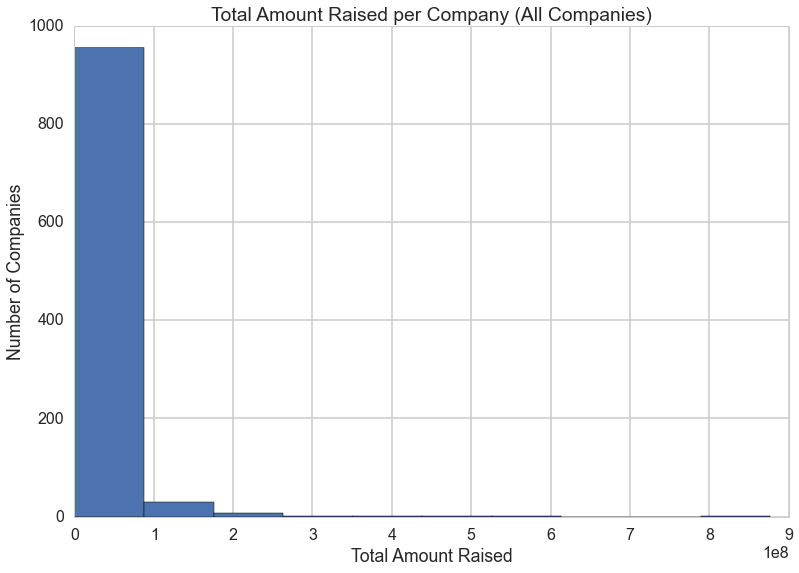

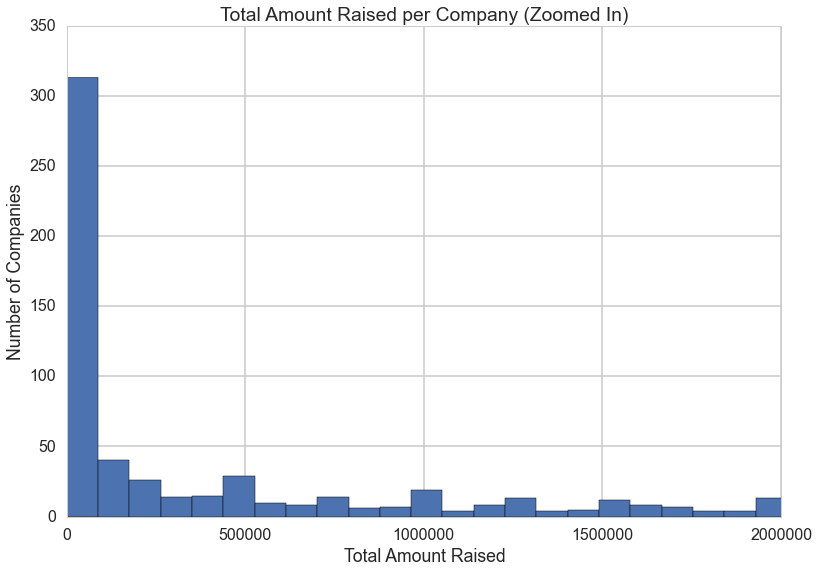

In [269]:
plt.hist(df.funding_total)
plt.title('Total Amount Raised per Company (All Companies)')
plt.xlabel('Total Amount Raised')
plt.ylabel('Number of Companies')
plt.show()

plt.xlim(0,2000000)
plt.hist(df.funding_total, bins=10000)
plt.title('Total Amount Raised per Company (Zoomed In)')
plt.xlabel('Total Amount Raised')
plt.ylabel('Number of Companies')
plt.show()

The majority of companies raised less than $500,000.  The amount of companies that raised a given amount very quickly drops off and goes into a long, sparse tail.  However, since this data is normally private, lots of rounds are missing their amounts.  We need to keep that in mind as we progress with our analysis.  

Let's take a look at the number of rounds each company raised:

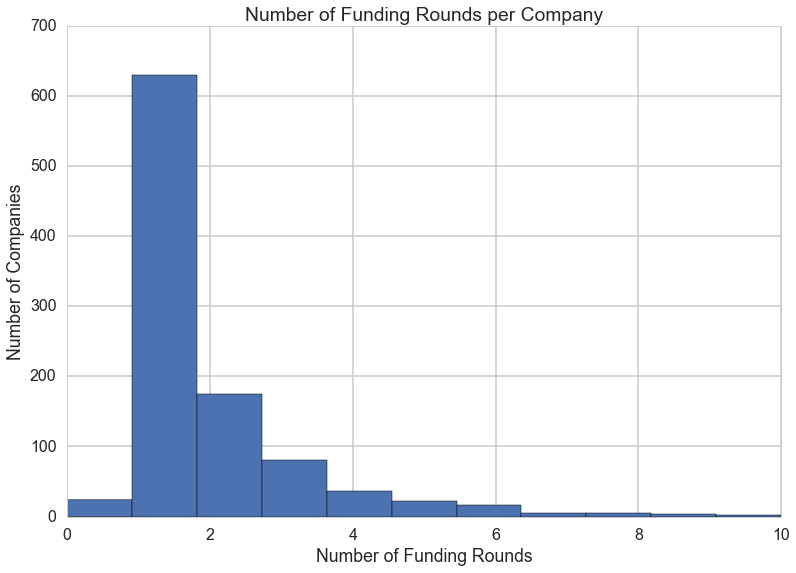

In [270]:
plt.hist(df.num_funding_rounds, bins=11)
plt.title('Number of Funding Rounds per Company')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Number of Companies')
plt.show()

Again, we see that most companies are clustered near the bottom of our range with 0, 1, or 2 rounds raised.  3 or more rounds raised is not very common.  Perhaps we can use that as an indicator of success, seeing as how it appears to be less sparse than the total amount raised column.  Perhaps this is due to the prevalence of companies and investors announcing that they raised a round, but not disclosing the exact amounts of that round.

Let's see how many companies out of our 1000 had at least 3 rounds:

In [346]:
print "Number of companies that raised at least 3 rounds: %s" % len(df[df.funding_amounts.map(lambda x: len(x) >= 3)])

Number of companies that raised at least 3 rounds: 172


That looks like a good number.  Let's add that as an indicator column to the dataframe, and see how many companies fall into one of our three indicator columns (Acquired, IPOed, > 3 Rounds Raised) now:

In [347]:
df['at_least_3_funding_rounds']=df.funding_amounts.map(lambda x: len(x) >= 3)

In [348]:
# Let's count how many companies match at least one of our success criteria:
print "Number of companies we consider to be a success: %s" % len(df[(df['at_least_3_funding_rounds'] == True) | (df['was_acquired'] == True) | (df['went_ipo'] == True)])

df['success'] = ((df['at_least_3_funding_rounds'] == True) | (df['was_acquired'] == True) | (df['went_ipo'] == True))
df['success'] = df.success.map(lambda x: 1 if x else 0)

Number of companies we consider to be a success: 259


So our success rate is around 25.9%. This may seem like a high success rate when compared to [other metrics about start-up success](http://www.forbes.com/sites/neilpatel/2015/01/16/90-of-startups-will-fail-heres-what-you-need-to-know-about-the-10/), but remember that the companies that make it into CrunchBase are already quite a selective bunch.  As we saw above, most companies in CrunchBase have already raised at least 1 round, so 25% may not seem that high, considering this is already a pretty select crowd of companies.

### Split the data

Let's split our dataset into training, validation and testing sets.  We need to clean up the columns first and separate the success column from the rest of the data.  We'll also, remove any columns that the success column is dependent on (went_ipo, was_acquired, etc....). 

Then we'll split out the testing data from the training data.  
// NOT SURE IF WE DO THIS // We'll then perform a second split on the training data to get the validation data.

In [359]:
cleandf = df.copy()

# Drop unnecessary columns
X = cleandf.drop(['success', 'competitors', 'at_least_3_funding_rounds', 'over_3_funding_rounds', 'was_acquired', 'went_ipo', 'funding_total', 'funding_mean', 'acquired_by', 'funding_rounds', 'investors', 'ipo', 'funding_dates', 'num_funding_rounds', 'funding_amounts', 'categories', 'text_nouns', 'text_adjectives', 'short_description', 'founder_ages'], axis=1)
# These columns can probably be converted to numerical form with 
# some positive impact on the models, so don't rule them out 
# completely just yet, but be careful that they are not dependent
# with any of our success indicators
X = X.drop(['acquisitions', 'board_members_and_advisors', 'founders', 'investments', 'offices', 'owned_by', 'headquarters', 'founder_names'], axis=1)
print X.shape

# The success column
y = df['success']
print y.shape
X.head()

(1000, 2179)
(1000,)


,c_Marketplaces_i,c_Crowdsourcing_i,c_Anything Capital Intensive_i,c_B2B_i,c_Corporate IT_i,c_Health and Insurance_i,c_Crowdfunding_i,c_Corporate Training_i,c_Incentives_i,c_Communications Infrastructure_i,c_Tourism_i,c_Cloud Data Services_i,c_Training_i,c_Automated Kiosk_i,c_Social Media Marketing_i,c_Restaurants_i,c_Portals_i,c_Clinical Trials_i,c_Testing_i,c_Water Purification_i,c_Health Services Industry_i,c_SNS_i,c_Non Profit_i,c_Telecommunications_i,c_Ticketing_i,c_Language Learning_i,c_Video Streaming_i,c_Mobile Payments_i,c_3D_i,c_Automotive_i,c_Collaboration_i,c_Interior Design_i,c_M2M_i,c_Game_i,c_Information Services_i,c_Unifed Communications_i,c_Health Care_i,c_All Students_i,c_Green_i,c_Distribution_i,c_Project Management_i,c_Cloud Computing_i,c_Home Decor_i,c_Audiobooks_i,c_User Experience Design_i,c_Blogging Platforms_i,c_Technology_i,c_Specialty Chemicals_i,c_Postal and Courier Services_i,c_Privacy_i,...,city_Tel Aviv-yafo_i,city_Johnston_i,city_Ruskin_i,city_Austin_i,city_Tel Aviv_i,city_Bucharest_i,city_Beijing_i,city_Fuzhou Shi_i,city_Caparica_i,city_Westmount_i,city_Preston_i,city_Pleasanton_i,city_Runcorn_i,city_Kanata_i,city_Gaithersburg_i,city_Beverly Hills_i,city_Guayabo_i,city_Upper Heyford_i,city_Vancouver_i,city_Chandigarh_i,city_Reading_i,city_Geneva_i,city_Cherry Hill_i,city_Princeton_i,city_Elkridge_i,city_Plymouth Meeting_i,city_Malvern_i,city_Mount Vernon_i,city_Miass_i,city_Stanford_i,city_Wilmington_i,city_Arnold_i,city_Melbourne_i,city_Plymouth_i,city_Longwood_i,city_Palo Alto_i,city_Almaty_i,city_Baltimore_i,city_Brentwood_i,city_Abingdon_i,city_New Haven_i,city_New Berlin_i,city_Amstelveen_i,city_Easley_i,city_Tourcoing_i,city_Oakland_i,city_Bra_i,founder_ages_mean,num_competitors,num_founders
24me,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,38,0,2
achieve-financial-services,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0
4tiitoo,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,2
128-technology,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [360]:
from sklearn.cross_validation import train_test_split
# Make the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Split the training data into train/validate set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, random_state=42)


# Training
print X_train.shape
print y_train.shape

# Validate
print X_validate.shape
print y_validate.shape

# Testing
print X_test.shape
print y_test.shape

(720, 2179)
(720,)
(180, 2179)
(180,)
(100, 2179)
(100,)


We will save these files now to ensure that we can come back to this point if needed.

In [361]:
X_train.to_csv("tmp/X_train.csv", index=False, header=True, encoding="utf-8")
y_train.to_csv("tmp/y_train.csv", index=False, header=True, encoding="utf-8")

X_validate.to_csv("tmp/X_validate.csv", index=False, header=True, encoding="utf-8")
y_validate.to_csv("tmp/y_validate.csv", index=False, header=True, encoding="utf-8")

X_test.to_csv("tmp/X_test.csv", index=False, header=True, encoding="utf-8")
y_test.to_csv("tmp/y_test.csv", index=False, header=True, encoding="utf-8")

# Bring out the Models

## The Baseline Model

Now we will attempt to find a baseline to improve upon. A basic baseline would be assuming that all companies fail or all companies succeed.  Let's take a look at what those two assumptions would yield.

In [363]:
# Assume all companies fail
print "Percentage guessed correct assuming all fail: %s" % (len(y_test[y_test == False]) / (1.0 * len(y_test)))

# Assume all companies succeed
print "Percentage guessed correct assuming all succeed: %s" % (len(y_test[y_test == True]) / (1.0 * len(y_test)))

Percentage guessed correct assuming all fail: 0.76
Percentage guessed correct assuming all succeed: 0.24


So the basic baseline to beat is 76%, which we get if we just assume all companies will fail.  That's not so hot.  Let's see if we can beat it.

## K-Nearest Neighbors

Here we will perform a K-Nearest Neighbors classification to predict if a company will be successful or not based upon the training data.  The two categories into which we will be classifying our data are succesful or not succesful.

Here we will use the [scikit-learn](http://scikit-learn.org/stable/modules/neighbors.html) KNeighborsClassifier to perform our classification.  We will start with the with weights set to 'uniform', which is the default and then try some other weighting formulas.

In [393]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights = 'uniform' and n_neighbors = 5: %s " % validate_accuracy

Validate accuracy with weights = 'uniform' and n_neighbors = 5: 0.55 


That's not so hot :( 

Perhaps if we increase the number of neigbors to query:

In [405]:
knc = KNeighborsClassifier(n_neighbors=20)
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights = 'uniform' and n_neighbors = 20: %s" % validate_accuracy

Validate accuracy with weights = 'uniform' and n_neighbors = 20: 0.794444444444


That's better!  We now have a model better than our baseline, although our baseline didn't set too high of a bar to begin with.  Let's graph the n_neighbors by accuracy:

In [399]:
# TODO GRAPH THE N_NEIGBORS (X-AXIS)  BY ACCURACY (Y-AXIS)!

//# TODO Conclusions from graph above

Now we'll try the KNeighborsClassifier with weights='distance':

In [403]:
knc = KNeighborsClassifier(n_neighbors=20, weights='distance')
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights='distance' and n_neighbors = 20: %s" % validate_accuracy

Validate accuracy with weights='distance' and n_neighbors = 20: 0.8


Awesome! 

In [401]:
# Let's see how our test data fares using this KNC
test_accuracy = knc.score(X_test,y_test)
print "Test accuracy with weights='distance' and n_neighbors = 20: %s" % test_accuracy

Test accuracy with weights='distance' and n_neighbors = 20: 0.78


## WHAT OTHER MODELS DO WE KNOW?

In [186]:
# TODO:

## Naive Bayes

In [ ]:
# TODO:

# Building an Ensemble

In [185]:
# TODO: